## FBE 499 Problem Set 3
----
Team: 123456

Names: Cynthia, Ruisha, Angel, Kiran

In [133]:
#-- Notebook Admin 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf 
import os 

wd = '/Users/kirankrishnamurthi/Library/CloudStorage/OneDrive-USCMarshallSchoolofBusiness/Fall 2022/FBE 499/Problem Sets/Problem Set 3'

os.chdir(wd)

#-- Options
pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn")

In [33]:
#-- Import Required Data

spy = pd.read_csv('SPY.csv', index_col = 'Date', parse_dates = ['Date'])
irx = pd.read_csv('^IRX.csv', index_col = 'Date', parse_dates = ['Date'])
russ = pd.read_csv('russell_adjclose.csv', index_col = 'Date', parse_dates = ['Date'])

### Question 1
---
The russell_adjclose.csv file contains adjusted closing prices for these four ETFs:

- IWF large cap growth stocks 
- IWD large cap value stocks 
- IWO small cap growth stocks 
- IWN small cap value stocks

Using ^IRX.csv, begin by computing excess returns on all four ETFs following the procedure used in Question 2 of Problem Set 2. (You may want to review my solutions.)

Now consider a strategy in which you allocate 25% of your portfolio to each ETF if it’s lagged adjusted closing price is above its 200-day moving average. If below, that 25% gets allocated to cash. Note that cash earns an excess rate of return of zero.

What are the mean, standard deviation, and annualized Sharpe ratio of this portfolio? (Assume 264 days in a year to annualize the Sharpe ratio.) Compare these statistics to the strategy that always puts 25% in each of the four ETFs.

In [34]:
#-- Compute T-Bill Yield Data --#

#-- Bind IRX data onto Russell and fill all missing values
russ['tbill_yield'] = irx['Close']
russ['tbill_yield_filled'] = russ['tbill_yield'].fillna(method = 'ffill')

#-- Day of Week Method from PS2 Solutions

russ['dow'] = russ.index.dayofweek
russ['lagdow'] = russ['dow'].shift()

russ['numdays'] = 1
russ.loc[russ['dow'] > (russ['lagdow']+1), 'numdays'] = russ['dow'] - russ['lagdow']
russ.loc[russ['dow'] < russ['lagdow'], 'numdays'] = 3 + russ['dow'] + (4 - russ['lagdow'])

#-- Force Fill for 9/11/2001
russ.loc['2001-09-17','numdays'] = 7

#-- Finalize Return Calculation 
russ['R_TB'] = russ['tbill_yield_filled'].shift() * russ['numdays'] / 365 / 100

#-- Output Check
russ.head()

,IWF,IWD,IWO,IWN,tbill_yield,tbill_yield_filled,dow,lagdow,numdays,R_TB
Date,,,,,,,,,,
2000-07-28,64.122047,32.991676,65.656059,22.564299,6.00,6.00,4,NaN,1,NaN
2000-07-31,65.001648,33.286224,66.335213,22.701979,6.02,6.02,0,4.0,3,0.000493
2000-08-01,65.319260,33.561806,65.683258,22.929138,6.06,6.06,1,0.0,1,0.000165
2000-08-02,64.622940,33.903889,65.995628,23.056480,6.05,6.05,2,1.0,1,0.000166
2000-08-03,65.453621,33.989399,65.221443,23.101213,6.04,6.04,3,2.0,1,0.000166


In [35]:
#-- Calculate Returns and 200-Day MA Adjusted Closing Prices for Each ETF

window = 200

#-- Excess Returns
russ['R_IWF'] = russ.IWF.pct_change(periods = 1) - russ.R_TB
russ['R_IWD'] = russ.IWD.pct_change(periods = 1) - russ.R_TB
russ['R_IWO'] = russ.IWO.pct_change(periods = 1) - russ.R_TB
russ['R_IWN'] = russ.IWN.pct_change(periods = 1) - russ.R_TB
russ['R_Cash'] = 0

#-- 200-Day Moving Averages
russ['IWF_200_MA'] = russ.IWF.rolling(window = window).mean()
russ['IWD_200_MA'] = russ.IWD.rolling(window = window).mean()
russ['IWO_200_MA'] = russ.IWO.rolling(window = window).mean()
russ['IWN_200_MA'] = russ.IWN.rolling(window = window).mean()

#-- Lagged Adjusted Closing Prices
russ['IWF_Lag'] = russ.IWF.shift(periods = 1)
russ['IWD_Lag'] = russ.IWD.shift(periods = 1)
russ['IWO_Lag'] = russ.IWO.shift(periods = 1)
russ['IWN_Lag'] = russ.IWN.shift(periods = 1)

#-- Remove NA Values
russ = russ.dropna(axis = 0)

#-- Output Check
russ.head()

,IWF,IWD,IWO,IWN,tbill_yield,tbill_yield_filled,dow,lagdow,numdays,R_TB,...,R_IWN,R_Cash,IWF_200_MA,IWD_200_MA,IWO_200_MA,IWN_200_MA,IWF_Lag,IWD_Lag,IWO_Lag,IWN_Lag
Date,,,,,,,,,,,,,,,,,,,,,
2001-05-14,44.635529,36.471096,52.562778,27.510923,3.61,3.61,0,4.0,3,0.000302,...,0.002540,0,54.434962,35.328467,58.792358,24.854830,44.737473,36.237823,53.067528,27.432934
2001-05-15,44.439445,36.538651,52.910851,27.600061,3.54,3.54,1,0.0,1,0.000099,...,0.003141,0,54.336549,35.346202,58.728632,24.880009,44.635529,36.471096,52.562778,27.510923
2001-05-16,46.157108,37.385803,54.433777,28.021252,3.48,3.48,2,1.0,1,0.000097,...,0.015163,0,54.242326,35.366700,58.669125,24.906605,44.439445,36.538651,52.910851,27.600061
2001-05-17,46.604160,37.441044,55.678226,28.157192,3.48,3.48,3,2.0,1,0.000095,...,0.004756,0,54.148751,35.386096,58.619100,24.932746,46.157108,37.385803,54.433777,28.021252
2001-05-18,46.502201,37.508587,55.800076,28.224037,3.51,3.51,4,3.0,1,0.000095,...,0.002279,0,54.058147,35.404120,58.568122,24.958583,46.604160,37.441044,55.678226,28.157192


In [84]:
#-- Implement Strategy

russ['wR_IWF'] = np.where(russ.IWF_Lag > russ.IWF_200_MA, .25, 0) * russ.R_IWF
russ['wR_IWD'] = np.where(russ.IWD_Lag > russ.IWD_200_MA, .25, 0) * russ.R_IWD
russ['wR_IWO'] = np.where(russ.IWO_Lag > russ.IWO_200_MA, .25, 0) * russ.R_IWO
russ['wR_IWN'] = np.where(russ.IWN_Lag > russ.IWN_200_MA, .25, 0) * russ.R_IWN

russ['wR_Cash'] = (1 - (russ.wIWF + russ.wIWD + russ.wIWO + russ.wIWN)) * russ.R_Cash

russ['Rp'] = russ.wR_IWF + russ.wR_IWD + russ.wR_IWO + russ.wR_IWN + russ.wR_Cash

#-- Check Strategy Output 
output = russ[['wR_IWF', 'wR_IWD', 'wR_IWO', 'wR_IWN', 'Rp']].describe()

output.loc['sharpe'] = (output.loc['mean'] * 252) / (output.loc['std'] * np.sqrt(252))

#-- Print Output Stats 
print('The annualized mean return of the portfolio is %f' % (output.loc['mean', 'Rp'] * 252))
print('The annualized volatility of the portfolio is %f' % (output.loc['std', 'Rp'] * np.sqrt(252)))
print('The annualized sharpe ratio of the portfolio is %f' % output.loc['sharpe', 'Rp'])

The annualized mean return of the portfolio is 0.056566
The annualized volatility of the portfolio is 0.116892
The annualized sharpe ratio of the portfolio is 0.483921


### Question 2
---
Using the SPY.csv and ^IRX.csv files located in the problem sets folder, implement a managed volatility strategy similar to that described in the PIMCO research note.

- Begin by computing excess returns on SPY, again following the procedure used in Question 2 of Problem Set 2.
- Compute 22-day rolling standard deviations of the excess returns. The weight in SPY on day t should be equal to .01/SD(t-1), where SD(t-1) is the 22-day rolling standard deviation as of date t-1.
- Compare the mean and standard deviation of this portfolio to a buy-and-hold position in SPY.
- Similar in spirit to Exhibit 3 of the PIMCO note, plot 264-day rolling standard deviations of the portfolio and of SPY.

In [88]:
#-- Compute T-Bill Yield Data and Excess Returns--#

#-- SPY Returns 
spy['R'] = spy['Adj Close'].pct_change(periods = 1)

#-- Bind IRX data onto Russell and fill all missing values
spy['tbill_yield'] = irx['Close']
spy['tbill_yield_filled'] = spy['tbill_yield'].fillna(method = 'ffill')

#-- Day of Week Method from PS2 Solutions

spy['dow'] = spy.index.dayofweek
spy['lagdow'] = spy['dow'].shift()

spy['numdays'] = 1
spy.loc[spy['dow'] > (spy['lagdow']+1), 'numdays'] = spy['dow'] - spy['lagdow']
spy.loc[spy['dow'] < spy['lagdow'], 'numdays'] = 3 + spy['dow'] + (4 - spy['lagdow'])

#-- Force Fill for 9/11/2001
spy.loc['2001-09-17','numdays'] = 7

#-- Finalize Return Calculation 
spy['R_TB'] = spy['tbill_yield_filled'].shift() * spy['numdays'] / 365 / 100


#-- Excess Returns 
spy['Re'] = spy.R - spy.R_TB

#-- Remove NA Values 
spy = spy.dropna(axis = 0)

#-- Output Check
spy[['tbill_yield_filled', 'R', 'R_TB', 'Re']].describe()

,tbill_yield_filled,R,R_TB,Re
count,7403.000000,7403.000000,7403.000000,7403.000000
mean,2.205814,0.000438,0.000087,0.000351
std,2.053200,0.011886,0.000108,0.011886
min,-0.105000,-0.109424,-0.000005,-0.109444
25%,0.125000,-0.004398,0.000004,-0.004468
50%,1.657000,0.000678,0.000051,0.000604
75%,4.490000,0.005928,0.000135,0.005860
max,6.220000,0.145197,0.000669,0.145180


<AxesSubplot:xlabel='Date'>

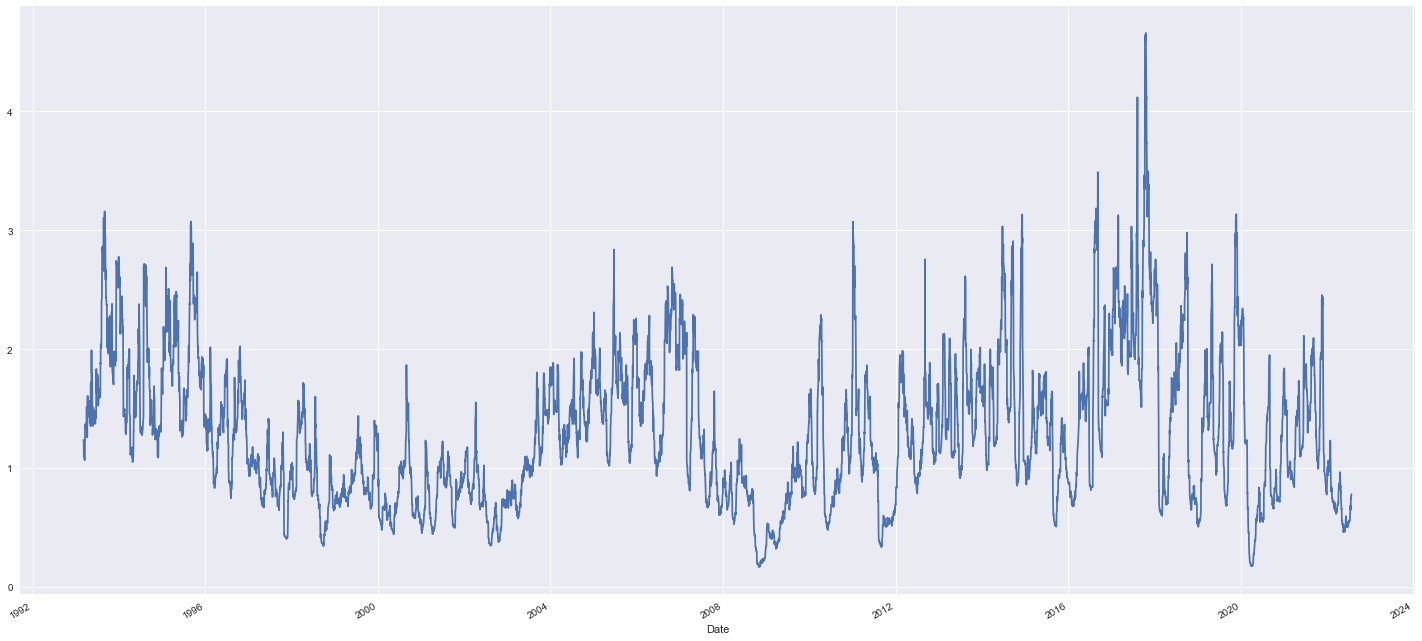

In [118]:
#-- Compute the rolling standard deviation and portfolio allocated weight 

spy['weight'] = .01 / (spy.Re.rolling(window = 22).std().shift(periods = 1))

spy.weight.plot(figsize = (25, 12))

In [97]:
#-- Compute Portfolio Stats

spy['Rp'] = spy.weight * spy.Re

spy.describe().loc[['mean', 'std'], ['Re', 'Rp']]

,Re,Rp
mean,0.000351,0.000387
std,0.011886,0.011064


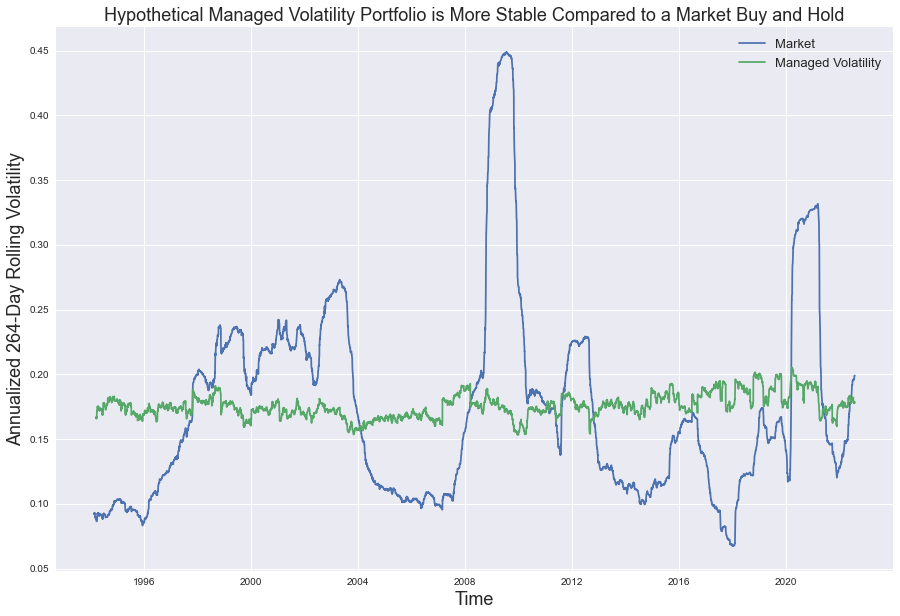

In [121]:
#-- Volatility Plot 1.0

plt.figure(figsize = (15, 10))

plt.plot(spy['Re'].rolling(window = 264).std() * np.sqrt(252))
plt.plot(spy['Rp'].rolling(window = 264).std() * np.sqrt(252))

plt.xlabel('Time', fontdict={'size' : 18})
plt.ylabel('Annualized 264-Day Rolling Volatility', fontdict={'size' : 18})
plt.title('Hypothetical Managed Volatility Portfolio is More Stable Compared to a Market Buy and Hold',
            fontdict = {'size' : 18})

plt.legend(fontsize = 13, labels = ['Market', 'Managed Volatility'])

plt.show()

### Question 3
---
Data for this question is from the Monthly tab of the PredictorData2021.xlsx file, which is in same folder as this file. It was downloaded from Amit Goyal’s website and is an updated version of the data Goyal used in his 2011 paper with Ivo Welch on return predictability. You can read in this data using pd.read_excel. Throw out all data before 1950.

The worksheet contains data that can be used to construct a number of predictors. These include:
- The D/P ratio (column C divided by column B)
- The term spread (column I minus column F)
- The default spread (column H minus column G)
- Net stock issuance (column J)

The sheet also contains market returns in column Q and risk-free returns in column K. Use them to compute the excess return on the market.

Run an out-of-sample analysis of a regression that uses the four predictive variables described above. The dependent variable is the excess market return in the next month. All regressions should use exactly 10 years of data. (Since you must lag the independent variables, you will have 119 observations in your regression.) Your first prediction will therefore be made in December of 1959, when you will be predicting the January 1960 return. Move the sample forward one month and repeat.

If m(t) is your return excess forecast at time t, then set your portfolio weight equal to 

$$ w(t) = min(1.5, max(0.5, 100 \times m(t))) $$


Note that the 100 is a lot different than the 8 used by Hull & Qiao. I am assuming that your market excess return forecasts will not be annualized. So if your expected return in the next month is .01 (a 1% return in the next month or 12% annualized), then you would put 100% of your money in the market index. Also note that the minimum weight is 0.5, rather than -0.5, as used by H&Q.

As with H&Q, assess both strategies using mean, standard deviation, and Sharpe. Report corresponding values for the strategy that simply puts 100% into the market.

In [132]:
#-- Load in Predictor Data

pred = pd.read_excel('PredictorData2021.xlsx')

#-- Add in Date Column
pred['Date'] = pd.to_datetime(pred['yyyymm'].astype('str').str[:4] + "-" + pred['yyyymm'].astype('str').str[-2:] + '-' + '01',format = '%Y-%m-%d')
pred = pred.set_index('Date')

#-- Filter Output
pred = pred.loc[pred['yyyymm'] >= 195001]

#-- Compute Factors and Returns
pred['f1'] = pred['D12'] / pred['Index']
pred['f2'] = pred['lty'] - pred['tbl']
pred['f3'] = pred['BAA'] - pred['AAA']
pred['f4'] = pred['ntis']
pred['Re'] = pred['CRSP_SPvw'] - pred['Rfree']

#-- Output Check
df = pred[['f1', 'f2', 'f3', 'f4', 'Re']]
df.head()

/Users/kirankrishnamurthi/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,f1,f2,f3,f4,Re
Date,,,,,
1950-01-01,0.0674,0.0108,0.0067,0.0271,0.0188
1950-02-01,0.0674,0.0102,0.0066,0.0255,0.0187
1950-03-01,0.0677,0.0103,0.0066,0.0293,0.0072
1950-04-01,0.0653,0.0099,0.0063,0.0264,0.0450
1950-05-01,0.0634,0.0097,0.0064,0.0286,0.0459


In [ ]:
#-- Looped Regression

df['pred'] = np.nan

for t in range(120 ,len(df)):

    dft = df.iloc[(t-120):t]

    regout = smf.ols('Re ~ f1 + f2 + f3 + f4', data = dft).fit()

    df['pred'].iloc[t] = regout.params[0] + regout.params[1] * dft['f1'].tail(1) + regout.params[2] * dft['f2'].tail(1) + regout.params[3] * dft['f3'].tail(1) + regout.params[4] * dft['f4'].tail(1)
    